# Определить экономически наиболее подходящее время для отключения работы генерирующих мощностей относительно цен РСВ

Рынок на сутки вперед (РСВ) – конкурентный отбор ценовых заявок поставщиков и покупателей за сутки до реальной поставки электроэнергии с определением цен и объемов поставки на каждый час наступающих суток. На РСВ цена зависит от часа суток, дня недели, периода года. 

Дано:
  - данные по  ценам РСВ за 2020-2024 год по Санкт-Петербургу
  - данные по средней цене РСВ за 2011-2024 год по Санкт-Петербургу
  - данные по температуре наружного воздуха за 2020-2024 года по Санкт-Петербургу
  - данные по температуре наружного воздуха за 2011-2024 года по Санкт-Петербургу    

Цель исследования:
    
    Определить экономически наиболее подходящее время для отключения работы генерирующих мощностей.

В связи с NDA, я не буду использовать полное описание данных, которые использую в работе. Также данные будут изменены в определенном формате для не расскрытия информации. В контексте конфиденциальности, я не раскрываю конкретную информацию о ТЭЦ.

## Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm


In [2]:
# выгружаем данные из excel
df = pd.read_excel('rsv.xlsx')
df_tnv = pd.read_excel('tnv.xlsx')

In [3]:
# функция для вывода информации по таблице и проверки на явные дубликаты
def df_main_info(df):
    display(df.head(3), df.info())
    display('Кол-во явных дубликатов: ', df.duplicated().sum())  

In [4]:
# Привести значения columns к нижнему регистру
df.columns = df.columns.str.lower()
# за 2021 нет средних цен за год, возьмем цены тэц-15
df['срзнач 21'] = df['тэц-15 2021']

translation_dict = {'unnamed: 0':'date'}

# Переименование столбцов
df.rename(columns=translation_dict, inplace=True)
# Заменяем возможные NaN значения на 0
df = df.fillna(0)

In [5]:
# Привести значения columns к нижнему регистру
df_tnv.columns = df_tnv.columns.str.lower()

translation_dict1 = {'месяц':'date'}

# Переименование столбцов
df_tnv.rename(columns=translation_dict1, inplace=True)

# Заменяем возможные NaN значения на 0
df_tnv = df_tnv.fillna(0)

In [6]:
df_tnv['date'] = df['date']

In [7]:
# Обьединение датасетов 
df_merge = df.merge(df_tnv, on='date' )

In [8]:
# Выводим среднюю температуру
df_merge['t_nv_avg'] = df_merge[['t_nv 2023','t_nv 2021','t_nv 2022','t_nv 2024']].mean(axis=1)
# Выводим среднюю температуру горячей воды
df_merge['teploset_avg'] = df_merge[['teploset 2023','teploset 2021','teploset 2022','teploset 2024']].mean(axis=1)


Выгрузка датасета с данными периода 2011-2024

In [9]:
rsv = pd.read_excel('rsv2.xlsx')
tnv = pd.read_excel('import.xlsx')

In [10]:
translation_dict = {'Unnamed: 0':'date'}

# Переименование столбцов
rsv.rename(columns=translation_dict, inplace=True)


In [11]:
# берем только дату и температуру наружного воздуха
tnv_copy = tnv[['date','tn_v']]

In [12]:
# Обьединение датасетов 
rsv_merge = rsv.merge(tnv_copy, on='date')

In [13]:
# Создаем столбцы с датой, меяцем и годом
rsv_merge['year'] = rsv_merge['date'].dt.year
rsv_merge['month'] = rsv_merge['date'].dt.month
rsv_merge['day'] = rsv_merge['date'].dt.day

In [14]:
# группируем по дню и месяцу столбцы
new_df_grouped = rsv_merge.pivot_table(index = ['month','day'], values=['rsv_fn','tn_v'], columns=['year'])
new_df_grouped = new_df_grouped.reset_index()
# переименовываем столбцы
new_df_grouped.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in new_df_grouped.columns]

# Создаем DataFrame с начальной датой 01-01 и конечной датой 31-12
dates = pd.date_range('2011-01-01', '2024-12-31', freq='D')
date_df = pd.DataFrame({'date': dates})

# Объединяем сгруппированный DataFrame с date_df
new_df_grouped['date'] = pd.to_datetime(date_df['date'])


In [15]:
# выводим среднюю за года т-ру и цену
new_grouped = rsv_merge.groupby(['month', 'day']).agg({'tn_v': 'mean', 'rsv_fn': 'mean'}).reset_index()
dates = pd.date_range('2024-01-01', '2024-12-31', freq='D')
date_df = pd.DataFrame({'date': dates})

# Объединяем сгруппированный DataFrame с date_df
new_grouped['date'] = pd.to_datetime(date_df['date'])

## Визуализация 

In [16]:
# выводим среднее за каждый год
year_mean = rsv_merge.groupby(['year']).agg({'tn_v': 'mean', 'rsv_fn': 'mean'}).reset_index()
year_mean

,year,tn_v,rsv_fn
0,2011,4.405435,887.558203
1,2012,5.626776,912.357156
2,2013,7.164932,1043.511719
3,2014,7.163288,1040.342951
4,2015,7.489863,1041.206023
5,2016,6.358197,1107.722118
6,2017,6.002192,1135.037568
7,2018,6.560000,1173.057810
8,2019,6.796438,1253.018209
9,2020,7.825683,1150.142115


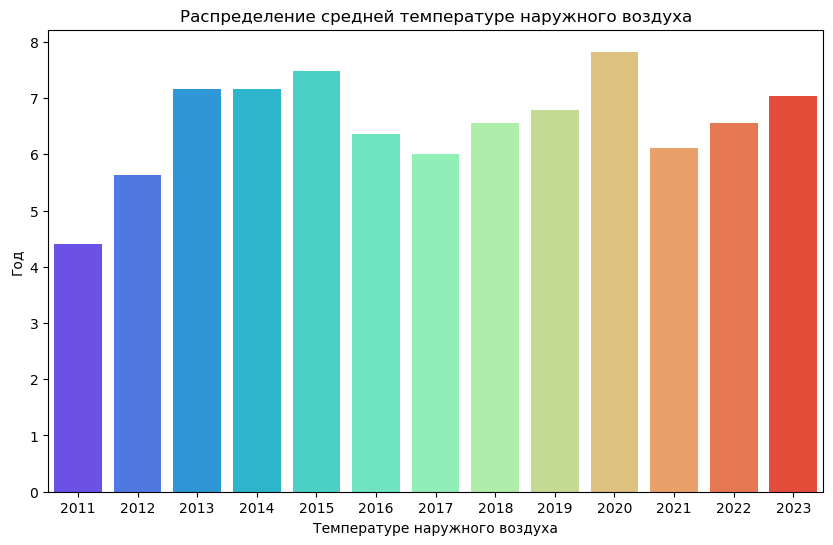

In [17]:
year_mean_full_year = year_mean.query('year != 2024')
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='tn_v', data=year_mean_full_year, palette='rainbow')
plt.xlabel('Температуре наружного воздуха')
plt.ylabel('Год')
plt.title('Распределение средней температуре наружного воздуха')
plt.show()

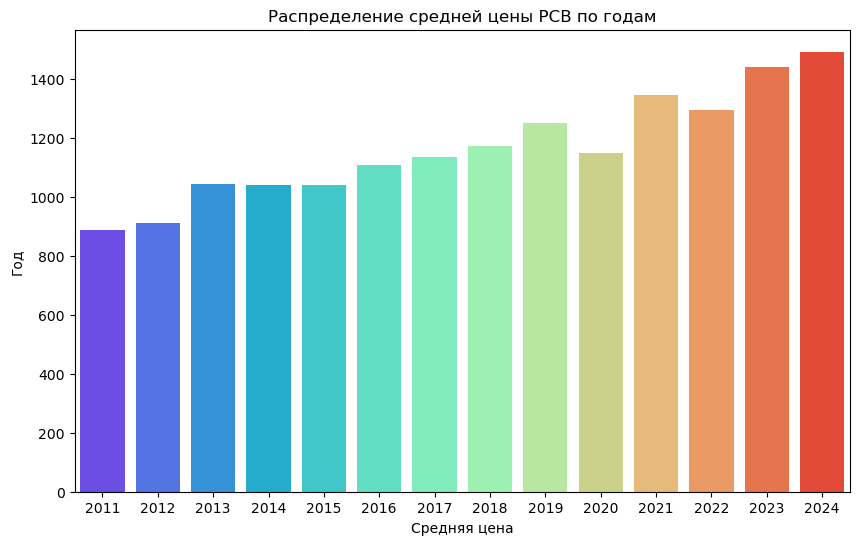

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='rsv_fn', data=year_mean, palette='rainbow')
plt.xlabel('Средняя цена')
plt.ylabel('Год')
plt.title('Распределение средней цены РСВ по годам')
plt.show()

Вывод: С годами цены непрерывно увеличиваются, что можно объяснить как инфляцией, так и ростом потребительского спроса. Однако отмечается, что в 2020 и 2022 годах наблюдается снижение средней цены, в отличие от общего тренда на рост. Это может быть связано с геополитическими событиями.

Построим гистограмму распределения цены рсв.

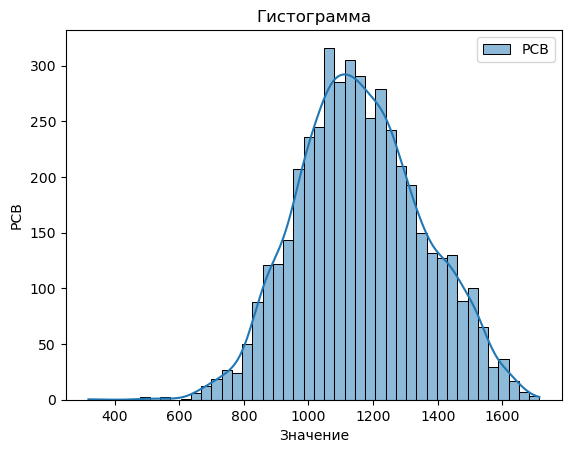

In [19]:
# Построим гистограмму для данных
sns.histplot(rsv_merge['rsv_fn'], kde=True, palette='rainbow', label='РСВ')

# Добавляем легенду
plt.legend()

# Добавляем подписи
plt.xlabel('Значение')
plt.ylabel('РСВ')
plt.title('Гистограмма')

# Показываем график
plt.show()

По графику видно что цена имеет близкое к нормальному распределение за 13 лет. Следовательно можно для анализа зависимости средней цены от времени года можно использовать среднюю подневную цену рсв за все 13 лет.

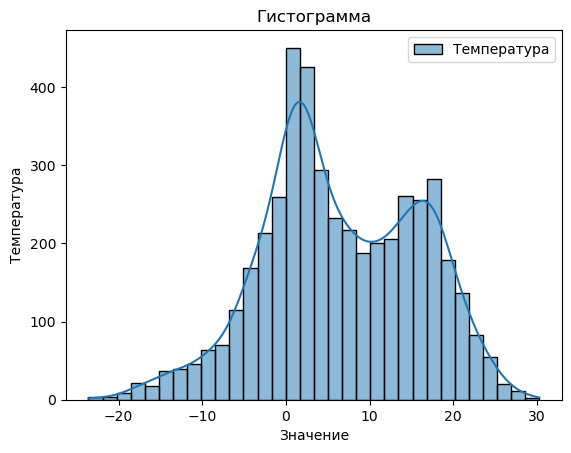

In [20]:
# Построим гистограмму для данных
sns.histplot(rsv_merge['tn_v'], kde=True, palette='rainbow', label='Температура')


# Добавляем легенду
plt.legend()

# Добавляем подписи
plt.xlabel('Значение')
plt.ylabel('Температура')
plt.title('Гистограмма')

# Показываем график
plt.show()

Построим по данным за 2021-2024 год первый график
на графике отобразим возможные параметры влияющие на цену РСВ.

In [23]:
data_to_average

,срзнач 21,срзнач 22,срзнач 23,срзнач 24
0,991.71,916.660997,1115.499710,937.536704
1,1161.15,1114.118352,1212.005312,1181.779082
2,1255.84,1148.059258,1215.506532,1298.693923
3,1295.89,1139.646755,1228.573914,1411.242856
4,1283.15,1198.624658,1213.105981,1454.051263
...,...,...,...,...
360,1415.74,1507.109964,1481.165833,NaN
361,1415.30,1447.539761,1410.951458,NaN
362,1518.61,0.000000,0.000000,NaN
363,1470.42,0.000000,0.000000,NaN


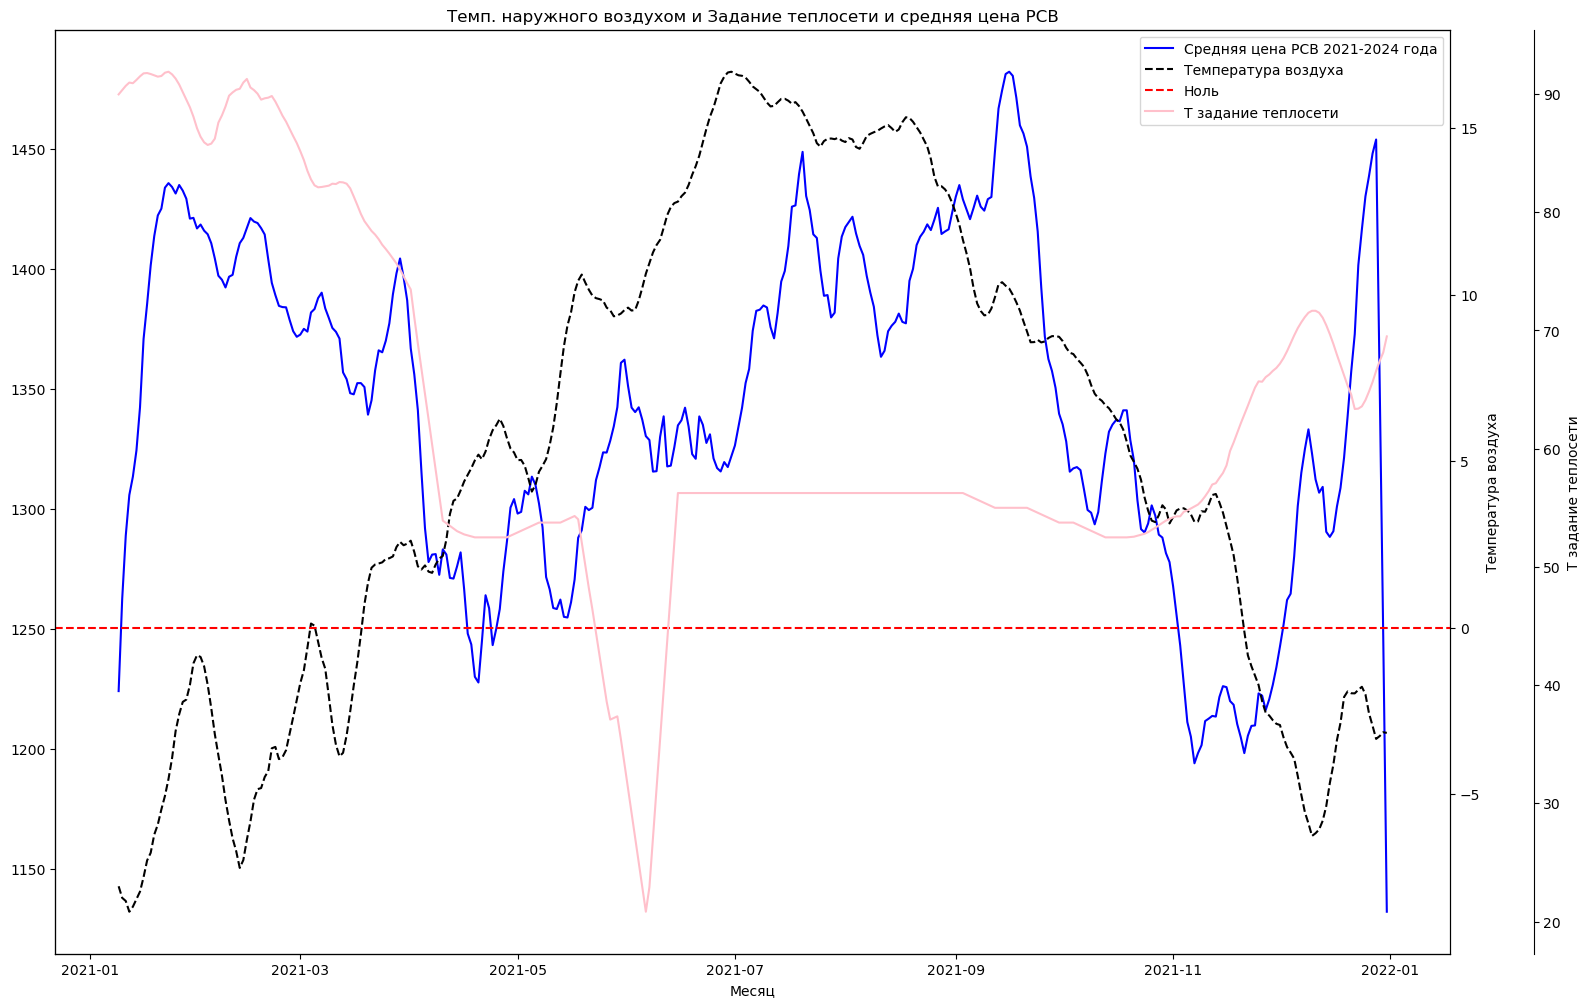

In [25]:
# Применение скользящего среднего
window_size = 9  # Размер окна для скользящего среднего

# Создание нового столбца с данными из всех четырех столбцов без учета 0 в 'срзнач 24'
data_to_average = df_merge[['срзнач 21', 'срзнач 22', 'срзнач 23']]
data_to_average['срзнач 24'] = df_merge['срзнач 24'].replace(0, pd.NA)
data_to_average['Combined'] = data_to_average.mean(axis=1).rolling(window=window_size).mean()

# Создание основного графика с matplotlib
fig, ax1 = plt.subplots(figsize=(18, 12))

# График для Combined
ax1.plot(df_merge['date'], data_to_average['Combined'], color='blue', label='Средняя цена РСВ 2021-2024 года')

# Добавляем легенду
ax1.legend()

# Создание второй оси y
ax2 = ax1.twinx()

# Дополнительный график t_nv_avg
ax2.plot(df_merge['date'], df_merge['t_nv_avg'].rolling(window=window_size).mean(), label='Температура воздуха', linestyle='--', color='black')
ax2.set_ylabel('Температура воздуха')

# Рисование нулевой линии
ax2.axhline(y=0, color='red', linestyle='--', label='Ноль')

# Создание третьей оси y
ax3 = ax1.twinx()

# Дополнительный график t_nv_avg
ax3.spines['right'].set_position(('outward', 60)) 
ax3.plot(df_merge['date'], df_merge['teploset_avg'].rolling(window=window_size).mean(), label='T задание теплосети', linestyle='-', color='pink')
ax3.set_ylabel('T задание теплосети')

# Настройка легенд и подписей
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')
ax1.set_xlabel('Месяц')
ax1.set_title('Темп. наружного воздухом и Задание теплосети и средняя цена РСВ')

plt.show()

Построим график цен РСВ и Температуры воздуха за 13 лет.

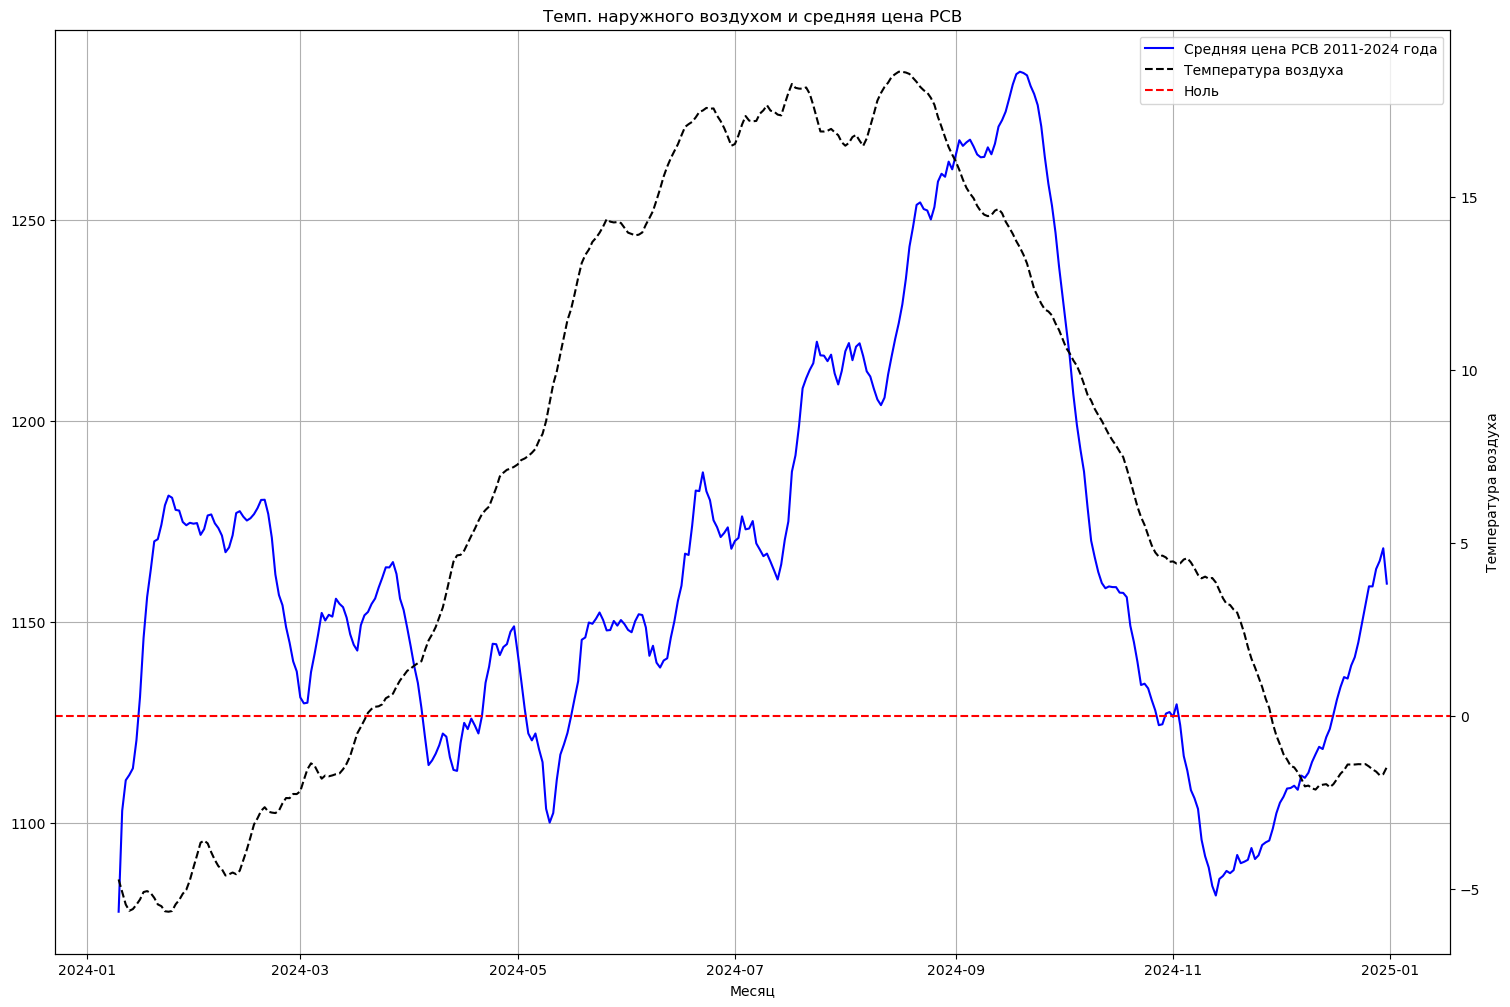

In [22]:
# Применение скользящего среднего
window_size = 10  # Размер окна для скользящего среднего

# Создание основного графика с matplotlib
fig, ax1 = plt.subplots(figsize=(18, 12))

# График для Combined
ax1.plot(new_grouped['date'], new_grouped['rsv_fn'].rolling(window=window_size).mean(),
         color='blue', label='Средняя цена РСВ 2011-2024 года')
ax1.legend()

# Создание второй оси y
ax2 = ax1.twinx()

# Дополнительный график t_nv_avg
ax2.plot(new_grouped['date'], new_grouped['tn_v'].rolling(window=window_size).mean(), label='Температура воздуха', linestyle='--', color='black')
ax2.set_ylabel('Температура воздуха')

# Рисование нулевой линии
ax2.axhline(y=0, color='red', linestyle='--', label='Ноль')

# Добавление сетки
ax1.grid(True)

# Настройка легенд и подписей
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines + lines2, labels + labels2, loc='upper right')
ax1.set_xlabel('Месяц')
ax1.set_title('Темп. наружного воздухом и средняя цена РСВ')

plt.show()

## Выводы

Прогнозирование цен на рынке на сутки вперед представляет собой очень сложную задачу, поскольку на цену влияет множество факторов, таких как погода, потребность в электроэнергии, объем предложений, периоды работы крупных генерирующих мощностей, таких как АЭС, паводок и другие скрытые факторы. В данной работе проведен анализ тенденций в распределении цен по временам года за длительный период времени, а также определение зависимости цены РСВ от погоды.

В первую очередь, мы заметили, что цена РСВ увеличивается с каждым годом, а её распределение можно описать как нормальное. Далее мы построили два графика, отображающих разные временные интервалы: 2021-2024 года и 2011-2024 года.

Из этих графиков можно сделать вывод, что пиковые значения цен приходятся на период с середины августа по октябрь. Это можно объяснить тем, что в этот период еще не начался межотопительный период, и станции работают на минимальной выработке. Самые низкие цены наблюдаются в октябре, что связано с низкими тепловыми потребностями в городе при достаточно высокой температуре, но уже началом межотопительного периода.

На первом графике можно увидеть, что при наступлении нулевой средней температуры воздуха цена резко возрастает. Это аномальное явление.

Также стоит исследовать периоды низов "пилы" и сравнить их с ценами текущего года. Возможно, существуют закономерности, связанные с внешними факторами, такими как вывод оборудования на плановый ремонт.

Для более корректного анализа требуется больше данных, таких как информация о ремонте оборудования, прогноз паводка, график включения и отключения крупных мощностей в регионе.